In [1]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

%matplotlib inline

In [2]:
import os
import requests
import zipfile

In [3]:
# Define the URL of the CSV file
url = "https://archive.ics.uci.edu/static/public/222/bank+marketing.zip"

In [4]:
# Check if the file already exists
if os.path.exists("bank_marketing.zip"):
    print("bank_marketing.zip already exists. Download canceled.")
else:
    # Download the file using requests (more secure and integrated)  
    response = requests.get(url)

    # Check for successful download
    if response.status_code == 200:
        # Write the data to a local ZIP file
        with open("bank_marketing.zip", "wb") as f:
            f.write(response.content)
        print("bank_marketing.zip downloaded successfully!")
    else:
        print(f"Error downloading file: {response.status_code}")

bank_marketing.zip downloaded successfully!


In [5]:
# Define the directory where the files will be extracted
extract_dir = "bank_marketing"

# Check if the directory already exists
if not os.path.exists(extract_dir):
    # Unzip the file only if the directory doesn't exist
    with zipfile.ZipFile("bank_marketing.zip", "r") as zip_ref:
        zip_ref.extractall(extract_dir)
        print(f"Files extracted to '{extract_dir}' directory.")
        print("Files extracted:", zip_ref.namelist())
else:
    print(f"Directory '{extract_dir}' already exists. Skipping extraction.")

Files extracted to 'bank_marketing' directory.
Files extracted: ['bank.zip', 'bank-additional.zip']


In [6]:
# Path to the bank.zip file
zip_path = "bank_marketing/bank.zip"
#extract_dir = "bank_marketing"

# Check if the bank.zip file exists
if os.path.exists(zip_path):
    # Open the zip file to check its contents
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        # Get the list of files in the zip
        extracted_files = zip_ref.namelist()

        # Check if the first file from the zip already exists in the extract directory
        first_file_path = os.path.join(extract_dir, extracted_files[0])
        if os.path.exists(first_file_path):
            print("Files already exist. Skipping extraction.")
        else:
            # If files don't exist, proceed with extraction
            zip_ref.extractall(extract_dir)
            print(f"bank.zip extracted to '{extract_dir}' directory.")
            print("Files extracted:", extracted_files)
else:
    print("bank.zip does not exist.")

bank.zip extracted to 'bank_marketing' directory.
Files extracted: ['bank-full.csv', 'bank-names.txt', 'bank.csv']


In [33]:
# Load the bank-full.csv file into a DataFrame
bank_data = pd.read_csv("bank_marketing/bank-full.csv", sep=';')  # Use the correct separator

In [34]:
bank_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [35]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [36]:
bank_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [37]:
# Remove the 'default' and 'loan' columns
bank_data = bank_data.drop(columns=['default', 'loan'])

In [39]:
nunique_values = bank_data.nunique()

# Create a list of unique values ​​for each column
#unique_values = [', '.join(map(str, bank_data[col].unique()[:5])) + ('...' if nunique_values[col] > 5 else '') 
#                 for col in bank_data.columns]
unique_values = [', '.join(map(str, bank_data[col].unique()))
                 for col in bank_data.columns]

# Create a new DataFrame with columns 'columns', 'nunique', and 'unique'
df_summary = pd.DataFrame({
    'columns': nunique_values.index,
    'nunique': nunique_values.values,
    'unique': unique_values
})

In [40]:
df_summary

,columns,nunique,unique
0,age,77,"58, 44, 33, 47, 35, 28, 42, 43, 41, 29, 53, 57..."
1,job,12,"management, technician, entrepreneur, blue-col..."
2,marital,3,"married, single, divorced"
3,education,4,"tertiary, secondary, unknown, primary"
4,balance,7168,"2143, 29, 2, 1506, 1, 231, 447, 121, 593, 270,..."
5,housing,2,"yes, no"
6,contact,3,"unknown, cellular, telephone"
7,day,31,"5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 19, 20, 21,..."
8,month,12,"may, jun, jul, aug, oct, nov, dec, jan, feb, m..."
9,duration,1573,"261, 151, 76, 92, 198, 139, 217, 380, 50, 55, ..."


In [41]:
# Creating the target variable:
y_values = {
    "yes": 1,
    "no": 0
}
bank_data["y"] = bank_data.y.map(y_values)
bank_data.sample(10)

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
5796,55,blue-collar,married,secondary,-473,yes,unknown,26,may,233,1,-1,0,unknown,0
15541,36,entrepreneur,married,tertiary,99,yes,cellular,21,jul,165,2,-1,0,unknown,0
26746,31,self-employed,single,secondary,148,yes,cellular,20,nov,1145,4,-1,0,unknown,0
25252,32,housemaid,married,tertiary,357,yes,cellular,18,nov,175,2,-1,0,unknown,0
24188,58,technician,married,secondary,-942,yes,cellular,17,nov,131,1,-1,0,unknown,0
29712,54,admin.,single,secondary,1178,yes,telephone,3,feb,41,6,264,2,failure,0
19904,33,management,married,tertiary,2604,no,cellular,8,aug,167,2,-1,0,unknown,0
7415,34,technician,married,secondary,149,yes,unknown,29,may,153,2,-1,0,unknown,0
11409,42,blue-collar,married,primary,692,no,unknown,19,jun,207,1,-1,0,unknown,0
14377,32,management,married,tertiary,2,yes,cellular,14,jul,79,3,-1,0,unknown,0


In [81]:
numerical = bank_data.select_dtypes(include=['number']).columns.tolist()
categorical = bank_data.select_dtypes(exclude=['number']).columns.tolist()

# Remove column 'y' from the numerical list
numerical.remove('y')

print("Numerical columns:", numerical)
print("Non-numerical columns:", categorical)

Numerical columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Non-numerical columns: ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']


In [69]:
# Splitting the dataset:
df_full_train, df_test = train_test_split(bank_data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y
y_val = df_val.y
y_test = df_test.y

del df_train['y']
del df_val['y']
del df_test['y']

## Question 1: ROC AUC feature importance

In [54]:
roc_auc_results = []

for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    
    # Format the AUC score to three decimal places
    formatted_auc = '%.3f' % auc
    roc_auc_results.append((c, formatted_auc))  # Store column name and formatted AUC score

# Convert results to a DataFrame
roc_auc_df = pd.DataFrame(roc_auc_results, columns=['Column', 'AUC'])

# Sort the DataFrame by AUC in descending order
roc_auc_df = roc_auc_df.sort_values(by='AUC', ascending=False)

# Get the column with the highest AUC
highest_auc_column = roc_auc_df.iloc[0]

print(roc_auc_df)
# Print the result
print(f"\nThe numerical variable with the highest AUC is `{highest_auc_column['Column']}` with an AUC of {highest_auc_column['AUC']}.")


     Column    AUC
3  duration  0.815
6  previous  0.599
5     pdays  0.590
1   balance  0.589
4  campaign  0.571
2       day  0.526
0       age  0.512

The numerical variable with the highest AUC is `duration` with an AUC of 0.815.


- Answer for Question1: duration

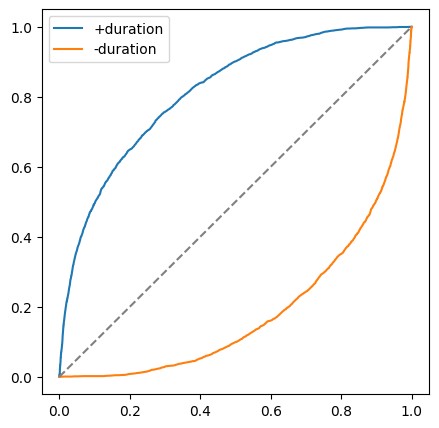

In [56]:
# Plotting the ROC Curve:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, df_train.duration)
plt.plot(fpr, tpr, label='+duration')

fpr, tpr, _ = roc_curve(y_train, -df_train.duration)
plt.plot(fpr, tpr, label='-duration')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

## Question 2: Training the model

In [111]:
# Training Logistic Regression Model:
columns = categorical + numerical

train_dicts = df_train[columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

In [112]:
# Inspecting ROC AUC Score:
round((roc_auc_score(y_val, y_pred)), 2)

np.float64(0.9)

- Answer for Question2: ~0.89

In [113]:
#@ INSPECTING THE ROC AUC SCORE:
y_pred_bin = model.predict(X_val)
roc_auc_score(y_val, y_pred_bin)

np.float64(0.6577696883650032)

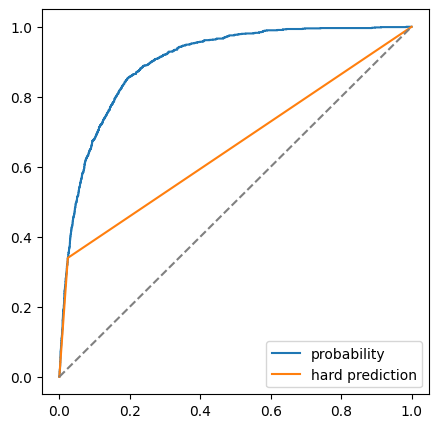

In [114]:
#@ INSPECTING THE ROC CURVE:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, label='probability')

fpr, tpr, _ = roc_curve(y_val, y_pred_bin)
plt.plot(fpr, tpr, label='hard prediction')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

In [115]:
#@ CREATING CONFUSION MATRIX:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores


#@ IMPLEMENTATION OF FUNCTION:
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,1098,7944,0,0
10,0.1,926,1493,172,6451
20,0.2,712,693,386,7251
30,0.3,566,407,532,7537
40,0.4,462,272,636,7672
50,0.5,373,192,725,7752
60,0.6,290,137,808,7807
70,0.7,225,101,873,7843
80,0.8,148,67,950,7877
90,0.9,76,27,1022,7917


In [116]:
#@ ADDING THE COLUMNS:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

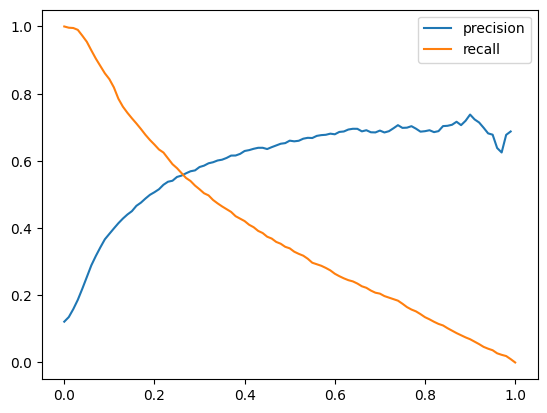

In [117]:
#@ INSPECTING THE CURVES:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.legend()
plt.show()

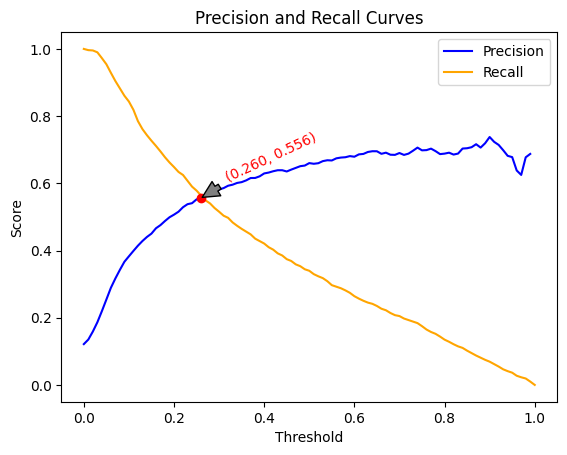

In [153]:
# Calculate the intersection points
intersection = np.isclose(df_scores.p, df_scores.r, atol=0.01)  # Adjust tolerance as needed
thresholds_intersection = df_scores.threshold[intersection]
precision_intersection = df_scores.p[intersection]
recall_intersection = df_scores.r[intersection]

# Plotting
#plt.figure(figsize=(8, 4))
plt.plot(df_scores.threshold, df_scores.p, label='Precision', color='blue')
plt.plot(df_scores.threshold, df_scores.r, label='Recall', color='orange')

# Marking the intersection points
for t, p, r in zip(thresholds_intersection, precision_intersection, recall_intersection):
    plt.plot(t, p, 'ro')  # Mark with red dot
    plt.annotate(f'({t:.3f}, {p:.3f})', xy=(t, p), xytext=(t + 0.05, p + 0.05), color='red', rotation=25,
                 arrowprops=dict(facecolor='grey', shrink=0.05))

plt.title('Precision and Recall Curves')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
#plt.grid()
plt.show()


In [154]:
# Print intersection points
for t, p, r in zip(thresholds_intersection, precision_intersection, recall_intersection):
    print(f"Threshold: {t:.3f}, Precision: {p:.3f}, Recall: {r:.3f} curves intersect")

Threshold: 0.260, Precision: 0.556, Recall: 0.564 curves intersect


- Answer for Question3: ~0.265

In [133]:
#@ GETTING F1 SCORES:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

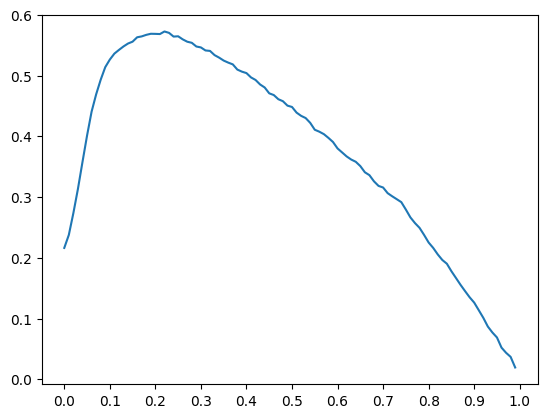

In [134]:
#@ INSPECTING F1 SCORE:
plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

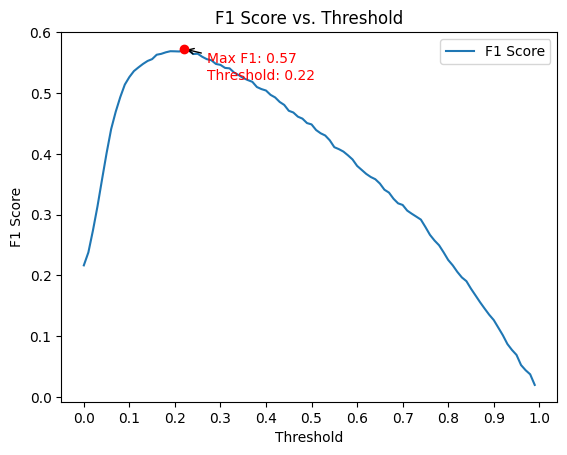

In [146]:
#import numpy as np
#import matplotlib.pyplot as plt

# Find the maximum F1 score and its corresponding threshold
max_f1 = df_scores['f1'].max()
max_f1_index = df_scores['f1'].idxmax()
max_threshold = df_scores['threshold'][max_f1_index]

# Plotting the F1 scores
#plt.figure(figsize=(10, 6))
plt.plot(df_scores.threshold, df_scores.f1, label='F1 Score')

# Mark the maximum F1 score
plt.scatter(max_threshold, max_f1, color='red', zorder=5)  # Add a red marker
plt.annotate(f'Max F1: {max_f1:.2f}\nThreshold: {max_threshold:.2f}', 
             xy=(max_threshold, max_f1), color='red',
             xytext=(max_threshold + 0.05, max_f1 - 0.05),  # Position the text
             arrowprops=dict(arrowstyle='->', color='black'))

# Formatting the plot
plt.title('F1 Score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.xticks(np.linspace(0, 1, 11))
plt.legend()
#plt.grid()
plt.show()


In [147]:
print(f"Threshold is {max_threshold:.2f} with F1 maximal {max_f1:.2f}")

Threshold is 0.22 with F1 maximal 0.57


- Answer for Question4: 0.22

In [148]:
#@ DEFINING TRAIN AND PREDICT FUNCTION:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [150]:
#@ INITIALIZING KFOLD CROSS VALIDATION:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y
    y_val = df_val.y

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.906 +- 0.006


- Answer for Question5: 0.006

In [155]:
#@ INSPECTING KFOLD CROSS VALIDATION:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.000001, 0.001, 1]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y
        y_val = df_val.y

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06, 0.701 +- 0.009
C=0.001, 0.861 +- 0.007
C=   1, 0.906 +- 0.006


- Answer for Question6: 1